In [1]:
%%capture
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
np.random.seed(42)  # don't change this line

import base64
import datetime
!pip install recommenders

In [2]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:45:29) 
[GCC 10.4.0]
Pandas version: 1.4.4
PySpark version: 3.3.0


In [58]:
path = "https://5190-hav-recommendation-data.s3.us-east-1.amazonaws.com/ratings_Electronics.csv"
data = pd.read_csv(path, header=None)
data.columns = ['userId', 'productId', 'rating', 'timestamp']
data
#takes 10s or so

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [59]:
user_rating_count = data['userId'].value_counts().rename('user_rating_count')
augmented_amazon_data = data.merge(user_rating_count.to_frame(), left_on='userId', right_index=True)
subset_df = augmented_amazon_data[augmented_amazon_data.user_rating_count >= 50]
print(subset_df.shape)
subset_df.head()
#10s

(125871, 5)


,userId,productId,rating,timestamp,user_rating_count
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,1118016000,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,1016668800,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,1258761600,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,1369872000,50


In [60]:
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='productId',
                                right_index=True)
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,rating,timestamp,user_rating_count,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,1369872000,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,1147305600,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,1358553600,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,1201132800,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,1331856000,65,18


In [61]:
data=product_rating_data

In [8]:
print(data.dtypes)

userId                    object
productId                 object
rating                   float64
timestamp                  int64
user_rating_count          int64
product_rating_counts      int64
dtype: object


In [63]:
data.sort_values(by=['timestamp'],inplace=True)

In [64]:
data

,userId,productId,rating,timestamp,user_rating_count,product_rating_counts
40702,A1RPTVW5VEOSI,B00004SB92,5.0,956966400,167,21
40387,AUITG1DJ3QUGK,B00004SB92,5.0,961200000,94,21
21343,A3A15L96IYUO6V,B00001P4XA,4.0,962236800,73,12
40261,ALUNVOQRXOZIA,B00004SB92,1.0,965347200,114,21
21317,ARXU3FESTWMJJ,B00001P4XA,3.0,966988800,137,12
...,...,...,...,...,...,...
7820216,A3G5MOHY1U635N,B00K91DB7Y,4.0,1405987200,80,26
7427171,A26BDXG9KVH7SU,B00DQZSIW8,4.0,1405987200,86,10
7801613,A3MFORLOKIOEQY,B00IVPU5BK,5.0,1405987200,103,12
7657417,A2R1HUYHXV7H18,B00FSA8VQ2,5.0,1405987200,59,35


In [65]:
ind=pd.DataFrame(data.userId.unique())
ind['index']=range(1, len(ind) + 1)
ind.rename(columns={0:'userId'},inplace=True)
ind
#data.join(ind,on='userId')

,userId,index
0,A1RPTVW5VEOSI,1
1,AUITG1DJ3QUGK,2
2,A3A15L96IYUO6V,3
3,ALUNVOQRXOZIA,4
4,ARXU3FESTWMJJ,5
...,...,...
1527,AC9QEWWN4W9MC,1528
1528,AGILRZOT49R0V,1529
1529,A3TR3KLL5PXSZ8,1530
1530,A3SU7JSTPH9CC9,1531


In [10]:
data.dtypes

userId                    object
productId                 object
rating                   float64
timestamp                  int64
user_rating_count          int64
product_rating_counts      int64
dtype: object

In [11]:
ind.dtypes

userId    object
index      int64
dtype: object

In [66]:
data=data.merge(ind,left_on='userId',right_on='userId')
data.drop(columns=['userId'],inplace=True)
data.rename(columns={'index':'userId'},inplace=True)

In [67]:
ind=pd.DataFrame(data.productId.unique())
ind['index']=range(1, len(ind) + 1)
ind.rename(columns={0:'productId'},inplace=True)


data=data.merge(ind,left_on='productId',right_on='productId')
data.drop(columns=['productId'],inplace=True)
data.rename(columns={'index':'productId'},inplace=True)
#data.join(ind,on='userId')

In [68]:
data=data[['userId','productId','rating','timestamp']]
data

,userId,productId,rating,timestamp
0,1,1,5.0,956966400
1,2,1,5.0,961200000
2,4,1,1.0,965347200
3,6,1,4.0,994204800
4,7,1,5.0,1006387200
...,...,...,...,...
42936,1216,2263,5.0,1315785600
42937,1246,2263,4.0,1341792000
42938,1301,2263,2.0,1338076800
42939,1346,2263,5.0,1339027200


In [69]:
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

data.head()

,userId,productId,rating,timestamp
0,1,1,5.0,956966400
1,2,1,5.0,961200000
2,4,1,1.0,965347200
3,6,1,4.0,994204800
4,7,1,5.0,1006387200


In [70]:
rows_count, columns_count = data.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)
print(data.dtypes)

Total Number of rows : 42941
Total Number of columns : 4
userId         int64
productId      int64
rating       float64
timestamp      int64
dtype: object


In [71]:
unique_userId = data['userId'].nunique()
unique_productId = data['productId'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  1532
Total number of unique Products :  2263


In [72]:
RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05
K = 5
#hyperparameters for us to vary

In [73]:
spark = start_or_get_spark("ALS Deep Dive", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

In [83]:
data.sort_values(by=['timestamp'],inplace=True)

In [85]:
print(len(data)/2)
data[0:]

21470.5


,userId,productId,rating,timestamp
0,1,1,5.0,956966400
1,2,1,5.0,961200000
2435,3,75,4.0,962236800
2,4,1,1.0,965347200
2436,5,75,3.0,966988800
...,...,...,...,...
35335,137,1714,4.0,1405987200
13617,683,532,4.0,1405987200
31609,159,1488,4.0,1405987200
35338,284,1714,1.0,1405987200


In [86]:
from pyspark.sql import SQLContext
from pyspark import SparkConf, SparkContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#sc.stop()
spark_df = sqlContext.createDataFrame(data)
early_df=sqlContext.createDataFrame(data[0:21471])
late_df=sqlContext.createDataFrame(data[21471:])
#took like 3mins
#on preprocessed takes a fewseconds

In [21]:
data['userId']

0           1
1           2
2           3
3           4
4           5
         ... 
42936    1123
42937    1187
42938    1236
42939    1344
42940    1439
Name: userId, Length: 42941, dtype: int64

In [22]:
spark_df.show(5)

+------+---------+------+----------+
|userId|productId|rating| timestamp|
+------+---------+------+----------+
|     1|        1|   5.0|1369872000|
|     2|        1|   5.0|1147305600|
|     3|        1|   4.0|1358553600|
|     4|        1|   4.0|1201132800|
|     5|        1|   5.0|1331856000|
+------+---------+------+----------+
only showing top 5 rows



In [23]:
train, test = spark_random_split(spark_df, ratio=0.70, seed=42)


In [24]:
data.dtypes

userId         int64
productId      int64
rating       float64
timestamp      int64
dtype: object

In [50]:
RANK = 7
MAX_ITER = 15
REG_PARAM = 0.3
K = 5
#hyperparameters for us to vary

In [51]:
COL_USER = "userId"
COL_ITEM = "productId"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(train)
#filtered data is quick

In [52]:
pred = model.transform(test).drop(COL_RATING)


In [53]:
evaluations = SparkRatingEvaluation(
    test, 
    pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)
#takes about 10s
#most filtered takes a couple secs

RMSE score = 0.9604767298667812
MAE score = 0.7651449404008703
R2 score = 0.018385239730794534
Explained variance score = 0.14577623178844934


In [87]:
train, test = spark_random_split(early_df, ratio=0.70, seed=42)


In [88]:
data.dtypes

userId         int64
productId      int64
rating       float64
timestamp      int64
dtype: object

In [89]:
RANK = 7
MAX_ITER = 15
REG_PARAM = 0.3
K = 5
#hyperparameters for us to vary

In [90]:
COL_USER = "userId"
COL_ITEM = "productId"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(train)
#filtered data is quick

In [91]:
pred = model.transform(test).drop(COL_RATING)


In [92]:
evaluations = SparkRatingEvaluation(
    test, 
    pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)
#takes about 10s
#most filtered takes a couple secs

RMSE score = 1.06044221274028
MAE score = 0.844911604745497
R2 score = -0.10931751426135694
Explained variance score = 0.06857826556558422


In [93]:
users = train.select(COL_USER).distinct()
items = train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
pred = model.transform(user_item)

# Remove seen items.
dfs_pred_exclude_train = pred.alias("pred").join(
    train.alias("train"),
    (pred[COL_USER] == train[COL_USER]) & (pred[COL_ITEM] == train[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()
#111s
#most filtered data takes 10s

23/04/26 21:04:06 WARN Column: Constructing trivially true equals predicate, 'userId#6946L = userId#6946L'. Perhaps you need to use aliases.


+------+---------+----------+
|userId|productId|prediction|
+------+---------+----------+
|     1|        3|  4.279279|
|     1|       17| 3.8900776|
|     1|       27|  4.216029|
|     1|       37| 4.0902247|
|     1|       39| 4.4270906|
|     1|       43|   4.16695|
|     1|       49| 3.5657268|
|     1|       80| 4.0793447|
|     1|       84| 3.9148052|
|     1|       88| 3.5722744|
|     1|       94| 4.1551685|
|     1|       96| 3.6293488|
|     1|      109| 4.0294547|
|     1|      116| 3.4008205|
|     1|      117|  4.163725|
|     1|      120| 3.5461385|
|     1|      121|  4.203488|
|     1|      122| 4.1429877|
|     1|      138| 2.9892302|
|     1|      146| 3.9662676|
+------+---------+----------+
only showing top 20 rows



In [94]:
evaluations = SparkRankingEvaluation(
    test, 
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)
#most filtered data takes 25s?

Precision@k = 0.002280130293159609
Recall@k = 0.002886193836926736
NDCG@k = 0.0028941579665227256
Mean average precision = 0.0011510117755028175


In [95]:
train, test = spark_random_split(late_df, ratio=0.70, seed=42)


In [88]:
data.dtypes

userId         int64
productId      int64
rating       float64
timestamp      int64
dtype: object

In [96]:
RANK = 7
MAX_ITER = 15
REG_PARAM = 0.3
K = 5
#hyperparameters for us to vary

In [97]:
COL_USER = "userId"
COL_ITEM = "productId"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(train)
#filtered data is quick

In [98]:
pred = model.transform(test).drop(COL_RATING)


In [99]:
evaluations = SparkRatingEvaluation(
    test, 
    pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)
#takes about 10s
#most filtered takes a couple secs

RMSE score = 0.9986790994344071
MAE score = 0.7829635712330564
R2 score = -0.18248053054187774
Explained variance score = 0.023266038858856586


In [100]:
users = train.select(COL_USER).distinct()
items = train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
pred = model.transform(user_item)

# Remove seen items.
dfs_pred_exclude_train = pred.alias("pred").join(
    train.alias("train"),
    (pred[COL_USER] == train[COL_USER]) & (pred[COL_ITEM] == train[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()
#111s
#most filtered data takes 10s

23/04/26 21:05:44 WARN Column: Constructing trivially true equals predicate, 'userId#6954L = userId#6954L'. Perhaps you need to use aliases.


+------+---------+----------+
|userId|productId|prediction|
+------+---------+----------+
|     1|       17| 2.6369596|
|     1|       20| 3.6579852|
|     1|       37| 3.7338634|
|     1|       39| 2.9417474|
|     1|       43| 3.5094543|
|     1|       49| 2.8262405|
|     1|       51| 3.1690292|
|     1|       52| 3.0907447|
|     1|       53| 3.1463275|
|     1|       60| 3.3820105|
|     1|       66| 3.3194892|
|     1|       94| 3.5455804|
|     1|       96| 3.7134585|
|     1|      107| 2.9630022|
|     1|      113| 3.6081545|
|     1|      117| 4.2287703|
|     1|      120| 3.1734307|
|     1|      121| 3.5135422|
|     1|      138| 3.3681269|
|     1|      146| 3.7781684|
+------+---------+----------+
only showing top 20 rows



In [101]:
evaluations = SparkRankingEvaluation(
    test, 
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)
#most filtered data takes 25s?

Precision@k = 0.0019801980198019807
Recall@k = 0.003126246690603126
NDCG@k = 0.0028578269398670487
Mean average precision = 0.0015856544445653367


In [36]:
param_dict = {
    "rank": [7, 10, 15],
    "regParam": [0.2, 0.3,0.4,0.5]
}
param_grid = generate_param_grid(param_dict)

In [37]:
param_grid

[{'rank': 7, 'regParam': 0.2},
 {'rank': 7, 'regParam': 0.3},
 {'rank': 7, 'regParam': 0.4},
 {'rank': 7, 'regParam': 0.5},
 {'rank': 10, 'regParam': 0.2},
 {'rank': 10, 'regParam': 0.3},
 {'rank': 10, 'regParam': 0.4},
 {'rank': 10, 'regParam': 0.5},
 {'rank': 15, 'regParam': 0.2},
 {'rank': 15, 'regParam': 0.3},
 {'rank': 15, 'regParam': 0.4},
 {'rank': 15, 'regParam': 0.5}]

In [42]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        maxIter=MAX_ITER,
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(train)
    
    pred = model.transform(test).drop(COL_RATING)
    
    evaluations = SparkRatingEvaluation(
        test, 
        pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )
    print(evaluations.rmse())
    print(g)
    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 
#most filtered data takes 90s

0.9691246881863134
{'rank': 7, 'regParam': 0.2}
0.9604767298667812
{'rank': 7, 'regParam': 0.3}
0.9770041330057792
{'rank': 7, 'regParam': 0.4}
1.0115384312384261
{'rank': 7, 'regParam': 0.5}
0.969708559537053
{'rank': 10, 'regParam': 0.2}
0.9635078202743756
{'rank': 10, 'regParam': 0.3}
0.9786490555824905
{'rank': 10, 'regParam': 0.4}
1.0120375615724755
{'rank': 10, 'regParam': 0.5}
0.9697924246608782
{'rank': 15, 'regParam': 0.2}
0.9630201879601222
{'rank': 15, 'regParam': 0.3}
0.9780508913288684
{'rank': 15, 'regParam': 0.4}
1.0118398308267131
{'rank': 15, 'regParam': 0.5}


In [44]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

<AxesSubplot:xlabel='reg. parameter', ylabel='rank'>

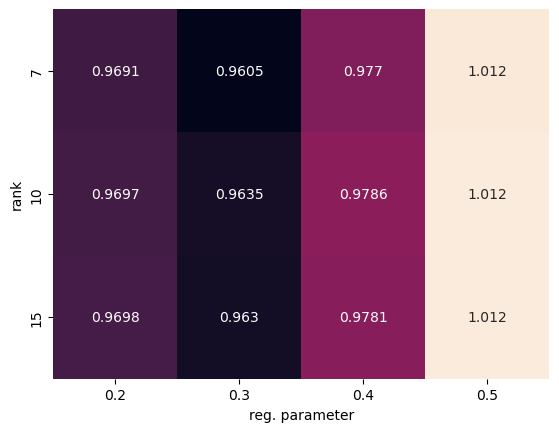

In [45]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")